In [27]:
import torch
import torch.nn.functional as F
import makemore_layers as ml
import random
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
words = open("names.txt").read().splitlines()

letters = sorted(list(set(''.join(words)))) #all letters from words

stoi = {l:i+1 for i, l in enumerate(letters)}
stoi['.'] = 0 #add '.' as start or end of the word
itos = {i:l for l, i in stoi.items()}

num_letters = len(stoi)
block_size = 8

In [67]:
def build_dataset(words):
    xs, ys = [], []
    for word in words:
        context = [0] * block_size
        for ch in word+'.':
            xs.append(context)
            nextInd = stoi[ch]
            ys.append(nextInd)
            context = context[1:]+[nextInd]
            
    return torch.tensor(xs), torch.tensor(ys)

random.seed(42)
random.shuffle(words)

ind1 = int(0.8*len(words))
ind2 = int(0.9*len(words))

x_tr, y_tr = build_dataset(words[:ind1])
x_dev, y_dev = build_dataset(words[ind1:ind2])
x_test, y_test = build_dataset(words[ind2:])

In [99]:
num_emb = 10
num_hidden = 100

model = ml.Sequential([
    ml.Embedding(num_letters, num_emb), 
    ml.FlattenConsecutive(2), ml.Linear(num_emb * 2, num_hidden, bias=False), ml.BatchNorm1d(num_hidden), ml.Tanh(),
    ml.FlattenConsecutive(2), ml.Linear(num_hidden * 2, num_hidden, bias=False), ml.BatchNorm1d(num_hidden), ml.Tanh(),
    ml.FlattenConsecutive(2), ml.Linear(num_hidden * 2, num_hidden, bias=False), ml.BatchNorm1d(num_hidden), ml.Tanh(),
    ml.Linear(num_hidden, num_letters, bias=False), ml.BatchNorm1d(num_letters),
])

with torch.no_grad():
    # normilize last layer
    model.layers[-1].gamma *= 0.1 
    # normilize weights for non-linear tanh function
    for layer in model.layers:
        if isinstance(layer, ml.Linear):
            layer.weights *= 5/3
    
parameters = model.parameters()
for p in parameters:
    p.requires_grad = True

In [100]:
inds = torch.randint(0, x_tr.shape[0], (4,))
x_b, y_b = x_tr[inds], y_tr[inds]
logits = model(x_b)

for layer in model.layers:
    print(layer.__class__.__name__, layer.out.shape)


Embedding torch.Size([4, 8, 10])
FlattenConsecutive torch.Size([4, 4, 20])
Linear torch.Size([4, 4, 100])
BatchNorm1d torch.Size([4, 4, 100])
Tanh torch.Size([4, 4, 100])
FlattenConsecutive torch.Size([4, 2, 200])
Linear torch.Size([4, 2, 100])
BatchNorm1d torch.Size([4, 2, 100])
Tanh torch.Size([4, 2, 100])
FlattenConsecutive torch.Size([4, 200])
Linear torch.Size([4, 100])
BatchNorm1d torch.Size([4, 100])
Tanh torch.Size([4, 100])
Linear torch.Size([4, 27])
BatchNorm1d torch.Size([4, 27])


In [102]:
losses = []

def training(epoch=200, batch_size=30, learning_rate=0.01):
    for i in range(epoch):
        # minibatch construct
        inds = torch.randint(0, x_tr.shape[0], (batch_size,))
        x_b, y_b = x_tr[inds], y_tr[inds]
        
        # forward pass
        logits = model(x_b)
        loss = F.cross_entropy(logits, y_b)
        if i % 1000 == 0: print(loss.item())

        # backward pass
        for p in parameters:
            p.grad = None
        loss.backward()
        
        # update
        for p in parameters:
            p.data -= learning_rate * p.grad
        
        # trace
        losses.append(loss.log10().item())
        
    print(loss.item())

for layer in model.layers:
    layer.training = True
     
training(epoch=200000, batch_size=50, learning_rate=0.05)

2.180359125137329
2.187832832336426
2.1160318851470947
2.393880844116211
2.141197919845581
2.1262834072113037
2.392890691757202
1.8826217651367188
2.3151304721832275
2.079636573791504
2.2042012214660645
2.0686609745025635
2.282721996307373
1.8239413499832153
2.097630023956299
2.0484213829040527
2.282015800476074
2.3756864070892334
1.9681705236434937
2.047938585281372
2.306656837463379
1.9886016845703125
2.269354820251465
2.2812883853912354
2.244271755218506
1.9567654132843018
1.9098070859909058
1.9664448499679565
1.8271487951278687
1.88869047164917
1.868190884590149
2.1466100215911865
1.8925377130508423
1.7824435234069824
2.3524703979492188
2.771313428878784
2.193821907043457
2.299844264984131
2.2758114337921143
1.8638538122177124
1.8383582830429077
2.027320623397827
2.4154129028320312
1.8348336219787598
2.044264554977417
2.1085050106048584
1.893645167350769
2.2032036781311035
2.1669111251831055
1.820926308631897
2.1368799209594727
2.587902307510376
1.905238151550293
1.7451508045196533

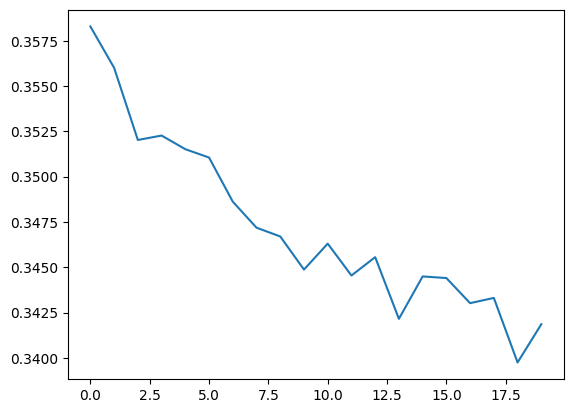

In [55]:
plt.plot(torch.tensor(losses).view(-1,1000).mean(1))

In [103]:
@torch.no_grad()
def get_loss(data):
    x, y = {
        'train': (x_tr, y_tr),
        'dev': (x_dev, y_dev),
        'test': (x_test, y_test)
    }[data]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(data, loss.item())

for layer in model.layers:
    layer.training = False
    
get_loss('train')
get_loss('dev')

train 1.844083547592163
dev 2.022813081741333


In [104]:
def generateName(g):
    result = ''
    ind = 0
    context = [0] * block_size 
    
    while True:
        logits = model([[context]])
        probs = F.softmax(logits, dim=1)

        ind = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        if ind == 0: break
        result += itos[ind]
        context = context[1:]+[ind]

    return result

g = torch.Generator().manual_seed(21474836327)

for layer in model.layers:
    layer.training = False
        
for _ in range(10):
    print(generateName(g))

novani
juliah
khalia
mareel
graith
delaniah
wellasia
arra
kiahli
shelen
